In [1]:

import matplotlib
import socket

if socket.gethostname() == "C02Z85AULVDC":
    matplotlib.use("macosx")

from pathlib import Path
import flexiznam as fzm
import bg_space as bgs
import bg_atlasapi as bga
import matplotlib.pyplot as plt
import itk
import numpy as np
from napari.viewer import Viewer
from brainglobe_napari_io.cellfinder import reader_xml
import tifffile

from cricksaw_analysis import atlas_utils

PROCESSED = Path("/camp/lab/znamenskiyp/home/shared/projects")
PROJECT = "hey2_3d-vision_foodres_20220101"
MOUSE = "PZAH6.4b"
REGISTRATION = "brainreg"
ATLAS_SIZE = 10
PEELED_SAVE_PATH = None
PROJECTION = "max"
SAVE_SVG = False

if REGISTRATION == "brainreg":
    DATA_FOLDER = PROCESSED / PROJECT / MOUSE / "brainreg_results" / "from_downsampled"
    imgs_path = dict(
        red=Path(DATA_FOLDER) / "downsampled_standard.tiff",
        blue=None,
        green=Path(DATA_FOLDER) / "downsampled_standard_2.tiff",
    )
    ATLAS_ANNOTATION = None
elif REGISTRATION == "elastix":
    DATA_FOLDER = PROCESSED / PROJECT / MOUSE / "registration_10"
    imgs_path = dict(
        red=None,
        blue=None,
        green=Path(DATA_FOLDER)
        / ("%ss_inverse_reg__elastix_out_step01" % MOUSE)
        / ("%ss_inverse_reg__registration_step01.mhd" % MOUSE),
    )
    resource_folder = Path("/camp/lab/znamenskiyp/home/shared/resources")
    atlas_resource = resource_folder / "cellfinder_resources/ARA_CCFv3"
    ATLAS_ANNOTATION = atlas_resource / ("ARA_%d_micron_mhd/atlas.mhd" % ATLAS_SIZE)
else:
    raise IOError("Registration must be `brainreg` or `elastix`")


PATH_TO_SAVE = DATA_FOLDER / "dorsal_view"
ATLAS_NAME = "allen_mouse_%dum" % ATLAS_SIZE
NAPARI = False

projs = dict(max=np.maximum, min=np.minimum, mean=np.add, sum=np.add)
projection_function = projs[PROJECTION.lower()]

if not PATH_TO_SAVE.is_dir():
    PATH_TO_SAVE.mkdir()

# do that first to crash early if there is a display issue
if NAPARI:
    viewer = Viewer()

PATH_TO_SAVE = Path(PATH_TO_SAVE)
# make sure it exists
PATH_TO_SAVE.mkdir(exist_ok=True)

print("Loading atlas")
bg_atlas = bga.bg_atlas.BrainGlobeAtlas(ATLAS_NAME)

# find layers
ctx_df = atlas_utils.create_ctx_table(bg_atlas)
layers = ["surface", "1", "2/3", "4", "5", "6a", "6b"]
if ATLAS_ANNOTATION is None:
    atlas_annot = bg_atlas.annotation
else:
    atlas_annot = itk.array_from_image(itk.imread(ATLAS_ANNOTATION))

Validation errors in config file(s).
The following fields have been reset to the default value:

schema_version
  value is not a valid tuple (type=type_error.tuple)



Loading atlas
allen mouse atlas (res. 10um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


In [2]:

# get registered data
print("Loading img data")
image_volumes = dict()
for col, pa in imgs_path.items():
    if pa is None:
        continue
    print("   loading %s channel" % col)
    image_volumes[col] = itk.array_from_image(itk.imread(str(pa)))


Loading img data
   loading red channel
   loading green channel


In [8]:
quant = np.quantile(image_volumes['green'][image_volumes['green'] != 0 ], 
                    [1e-4, 1e-3, 1e-2, 0.1, 0.9])
print(quant)

[1.000e+00 1.000e+00 1.000e+00 2.000e+00 1.241e+03]


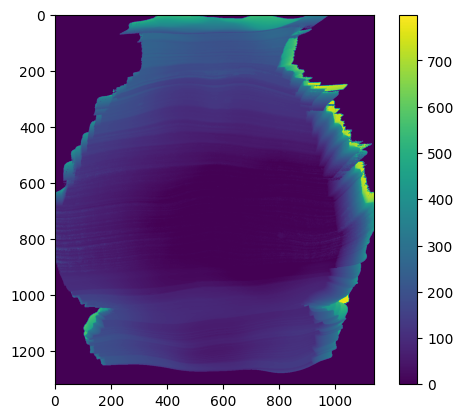

In [11]:
threshold = 2
thresh_data = np.zeros_like(image_volumes['green'])
mask = image_volumes['green'] > threshold
thresh_data[mask] = image_volumes['green'][mask]
data_from_top = atlas_utils.external_view(
        thresh_data, axis="dorsal", border_only=False, get_index=True, which="first"
    )
plt.imshow(data_from_top)
plt.colorbar()